In [1]:
import onnxruntime as ort
import numpy as np

ort_encoder = ort.InferenceSession('vae_encoder_dense.onnx')
ort_decoder = ort.InferenceSession('vae_decoder_dense.onnx')

2025-01-30 17:49:22.385761023 [W:onnxruntime:, graph.cc:109 MergeShapeInfo] Error merging shape info for output. 'sym_size_int' source:{} target:{1}. Falling back to lenient merge.


In [2]:
import pandas as pd

file = "/home/doserbd/data/gaia/xp_continuous_mean_spectrum/csv/XpContinuousMeanSpectrum_000000-003111.csv.gz"
gaia = pd.read_csv(file, comment='#', nrows=10)

In [3]:
list_of_arrays = [
    "bp_coefficients",
    "bp_coefficient_errors",
    "bp_coefficient_correlations",
    "rp_coefficients",
    "rp_coefficient_errors",
    "rp_coefficient_correlations",
]

for array in list_of_arrays:
    gaia[array] = gaia[array].apply(
        lambda x: np.fromstring(x[1:-1], dtype=np.float32, sep=",")
    )

In [4]:
xp = gaia.apply(
    lambda x: np.concatenate((x["bp_coefficients"], x["rp_coefficients"])), axis=1
)
max = xp.apply(lambda x: np.max(np.abs(x)))
max

0      113.551781
1     3313.824951
2      421.914703
3      432.963440
4    14257.696289
5    14270.630859
6     2146.528809
7     1123.897705
8     2425.099854
9      249.233246
dtype: float32

In [5]:
gaia["bp_coefficients"] = gaia["bp_coefficients"] / max
gaia["rp_coefficients"] = gaia["rp_coefficients"] / max
xp = xp / max

In [6]:
from gaiaxpy import calibrate

calibrated_spectrum, sampling = calibrate(
    gaia, sampling=np.arange(336, 1021, 2), save_file=False
)

In [7]:
data = np.array(xp.values.tolist())
data.shape

(10, 110)

In [8]:
z = ort_encoder.run(['div'], {'l_x_': data})
recon = ort_decoder.run(None, {'l_x_': z[0]})
recon[0].shape

(10, 110)

In [ ]:
gaia_recon = gaia.copy()
for i in range(10):
    gaia_recon["bp_coefficients"][i] = recon[0][i][:55]
    gaia_recon["rp_coefficients"][i] = recon[0][i][55:]

/tmp/ipykernel_525954/150788826.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  gaia_recon["bp_coefficients"][i] = recon[0][i][:55]
/tmp/ipykernel_525954/150788826.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pan

In [10]:
recon_spectrum, sampling = calibrate(
    gaia_recon, sampling=np.arange(336, 1021, 2), save_file=False
)

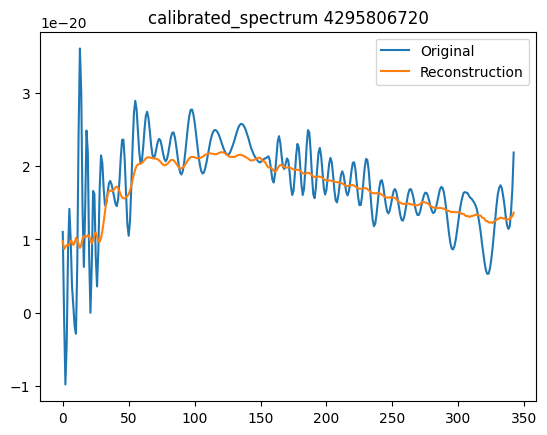

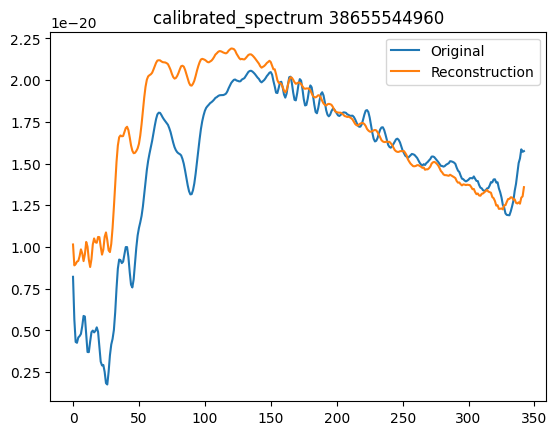

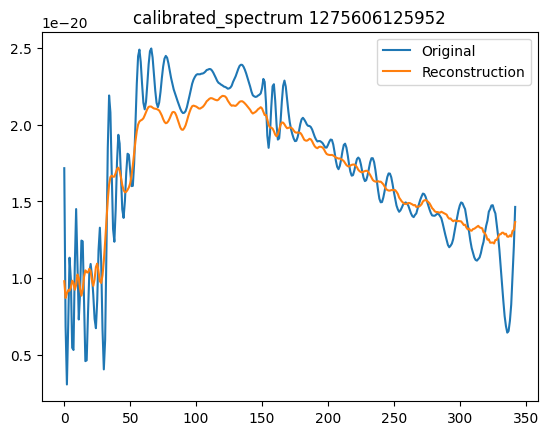

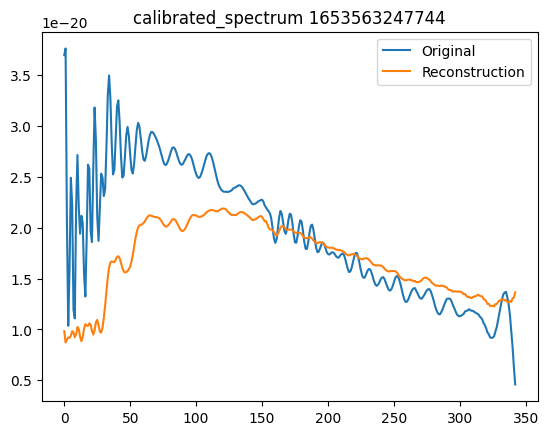

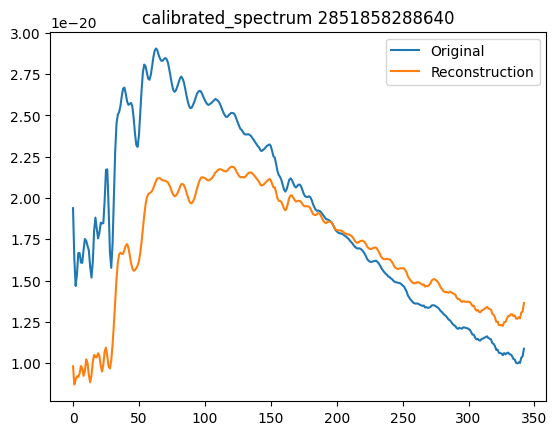

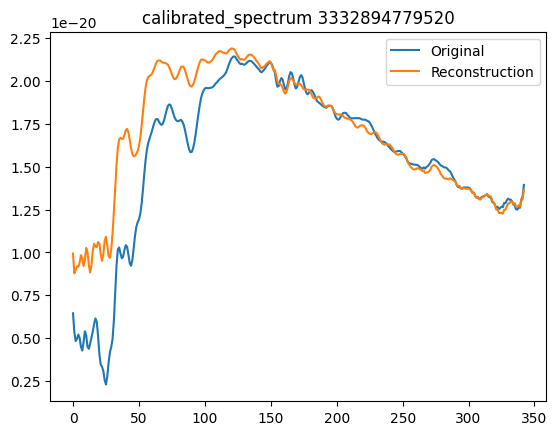

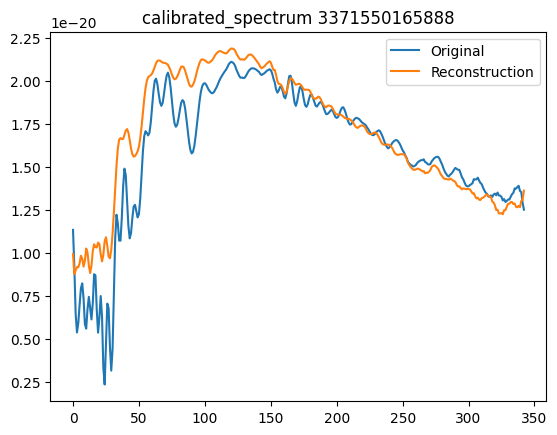

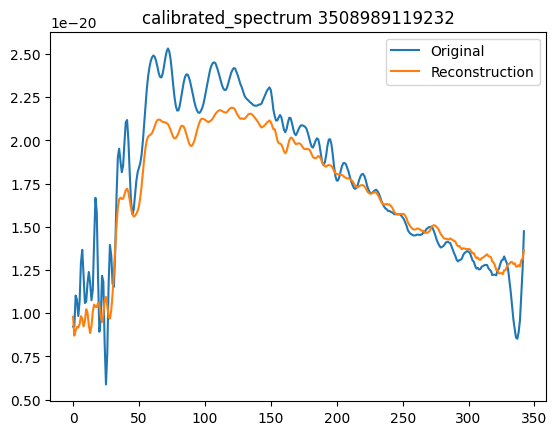

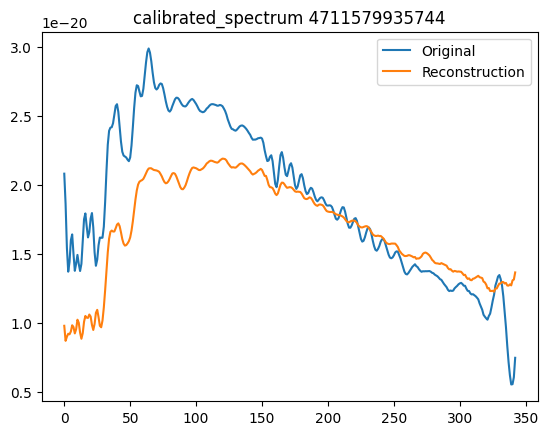

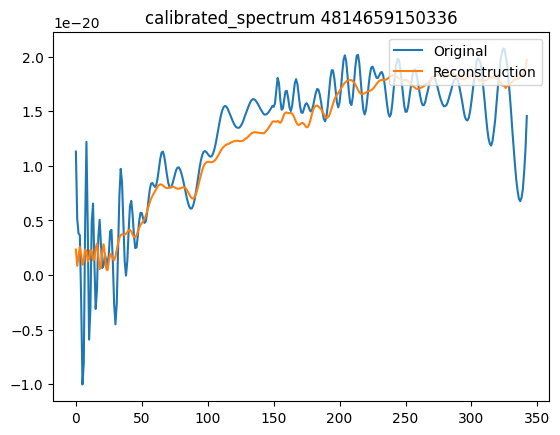

In [11]:
from matplotlib import pyplot as plt

for idx in range(10):
# for idx in [0]:
    plt.figure()
    plt.title(f"calibrated_spectrum {gaia["source_id"][idx]}")
    plt.plot(calibrated_spectrum["flux"][idx], label="Original")
    plt.plot(recon_spectrum["flux"][idx], label="Reconstruction")
    plt.legend(loc="upper right")
    plt.show()

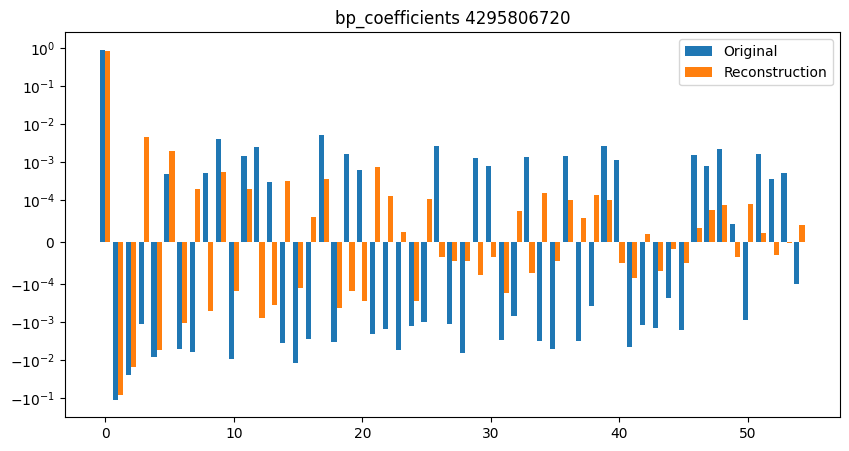

<Figure size 640x480 with 0 Axes>

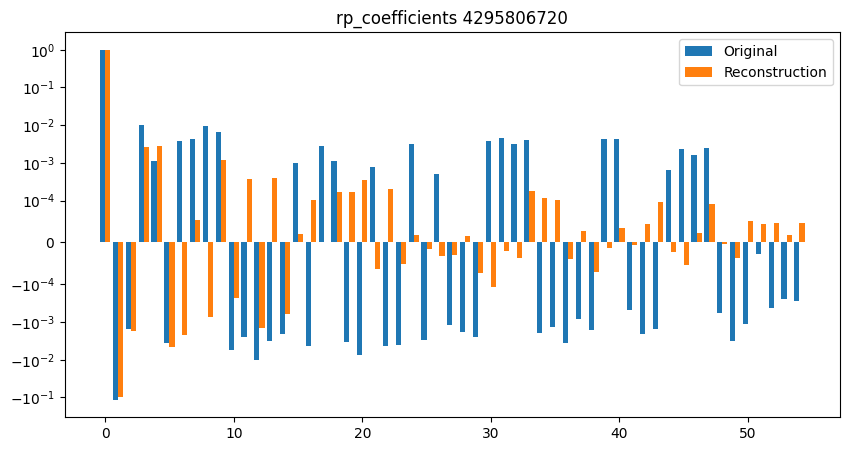

<Figure size 640x480 with 0 Axes>

In [12]:
idx = 0
for type in ["bp_coefficients", "rp_coefficients"]:
    x = np.array(range(55))
    plt.figure(figsize=(10, 5))
    plt.title(f"{type} {gaia["source_id"][idx]}")
    # plt.bar(x-0.2, gaia[type][idx][:40], label=f"orig", width=0.4)
    # plt.bar(x+0.2, gaia_recon["bp_coefficients"][idx][:40], label=f"recon", width=0.4)
    plt.bar(x-0.2, gaia[type][idx], label="Original", width=0.4)
    plt.bar(x+0.2, gaia_recon[type][idx], label="Reconstruction", width=0.4)
    plt.legend(loc="upper right")
    plt.yscale('symlog', linthresh=1e-4)
    # plt.ylim([-10, 10])
    plt.show()
    # plt.savefig(f"{type}.png")

In [13]:
idx = 1

gaia_base = gaia.copy()
# gaia_base["bp_coefficients"][0] = np.zeros(55)
# gaia_base["rp_coefficients"][0] = np.zeros(55)
gaia_base["bp_coefficients"][idx][0] = gaia["bp_coefficients"][idx][0] * 0.9
# gaia_base["rp_coefficients"][0][0] = 1.0

In [14]:
base_spectrum, sampling = calibrate(
    gaia_base, sampling=np.arange(336, 1021, 2), save_file=False
)

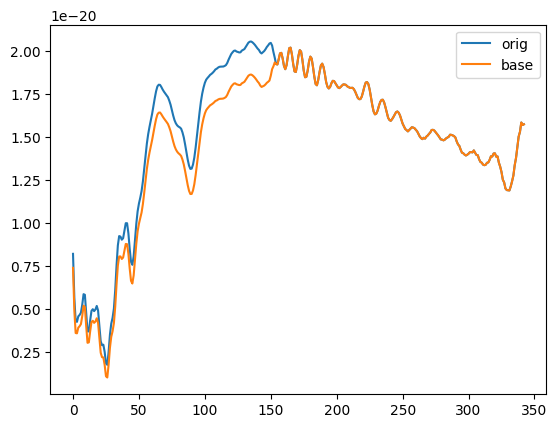

In [15]:
plt.figure()
plt.plot(calibrated_spectrum["flux"][idx], label=f"orig")
plt.plot(base_spectrum["flux"][idx], label=f"base")
plt.legend(loc="upper right")
plt.show()